In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
from dataloaders import CLIC
import matplotlib.pyplot as plt
import numpy as np
from annotator.canny import CannyDetector
from annotator.util import HWC3, resize_image
import os, zlib, sys

In [19]:
!gunzip recon_examples/clic_val_recon/0_caption.txt.gz

In [20]:
os.path.getsize('recon_examples/clic_val_recon/0_caption.txt')*8

192

In [4]:
caption = 'a jellyfish in the water'

In [9]:
caption = 'oversight disproportwemargarita sixties past orioles spatial exhibitions jacobson adelsailing championships imsa sailing sailing '

In [13]:
sys.getsizeof(caption)*8
sys.getsizeof(zlib.compress(caption.encode()))*8 / (512*512)

0.003936767578125

In [4]:
clic = CLIC(root='/home/Shared/image_datasets/CLIC/2021', batch_size=1)

In [5]:
len(clic.train_dset)

585

In [6]:
len(clic.val_dset)

41

In [6]:
apply_canny = CannyDetector()

model = create_model('./models/cldm_v15.yaml').cpu()
model.load_state_dict(load_state_dict('./models/control_sd15_canny.pth', location='cuda'))
model = model.cuda()

No module 'xformers'. Proceeding without it.
ControlLDM: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Loaded model config from [./models/cldm_v15.yaml]
Loaded state_dict from [./models/control_sd15_canny.pth]


In [7]:
from models_blip.blip import blip_decoder

model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth'
blip = blip_decoder(pretrained=model_url, image_size=384, vit='base')
blip.eval()
blip = blip.cuda()

reshape position embedding from 196 to 576
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth


In [13]:
def encode(model, im):
    apply_canny = CannyDetector()
    canny_map = HWC3(apply_canny(im, 100, 200))
    return canny_map

def recon(model, canny_map, prompt):
    dec = decode(model, canny_map, prompt, num_samples=2)
    return dec

def encode_rcc(model, blip, im, N=5):
    apply_canny = CannyDetector()
    canny_map = HWC3(apply_canny(im, 100, 200))
    caption = caption_blip(blip, im)[0]
    dec_samples, seed = decode(model, canny_map, caption, seed=-1, num_samples=N) # first one is the edge map
    dec_samples = np.stack(dec_samples[1:]) # [num_samples, w, h, 3]
    loss = np.sum((np.repeat(im[None, :], N, axis=0)-dec_samples)**2, axis=(1,2,3))
    idx = np.argmin(loss)
    return canny_map, caption, idx, seed

def recon_rcc(model, canny_map, prompt, idx, seed, N=5):
    dec_samples = decode(model, canny_map, prompt, seed=seed, num_samples=N) # first one is the edge map
    canny_map = dec_samples[0]
    dec_samples = np.stack(dec_samples[1:]) # [num_samples, w, h, 3]
    return canny_map, dec_samples[idx,:]




from PIL import Image
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

def blip_preprocess(image, image_size):
    transform = transforms.Compose([
        transforms.Resize((image_size,image_size),interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ]) 
    image = transform(image).unsqueeze(0).cuda()
    return image

def caption_blip(blip, im):
    im = Image.fromarray(im)
    im = blip_preprocess(im, 384)
    with torch.no_grad():
        # beam search
        caption = blip.generate(im, sample=False, num_beams=3, max_length=20, min_length=5) 
        # nucleus sampling
        # caption = model.generate(image, sample=True, top_p=0.9, max_length=20, min_length=5) 
    return caption

In [9]:
len(clic.val_dset)

41

In [10]:
i = 14
x = clic.val_dset[i][0]
x_im = (255*x.permute(1,2,0)).numpy().astype(np.uint8)
im = resize_image(HWC3(x_im), 512)

In [11]:
canny_map, caption, idx, seed = encode_rcc(model, blip, im, 4)
print(caption, idx)

Global seed set to 62602


Data shape for DDIM sampling is (4, 4, 64, 96), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:32<00:00,  1.65s/it]


a hot pool in the mountains 1


In [14]:
canny_map, xhat = recon_rcc(model, canny_map, caption, idx, seed, 4)

Global seed set to 62602


Data shape for DDIM sampling is (4, 4, 64, 96), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:33<00:00,  1.66s/it]


: 

In [91]:
canny_map = encode(model, im)
caption = caption_blip(blip, im)[0]
print(caption)
xhat = recon(model, canny_map, caption)

Global seed set to 21866


a group of people sitting on the edge of a cliff
Data shape for DDIM sampling is (2, 4, 64, 96), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:16<00:00,  1.18it/s]


In [121]:
xhat.shape

(512, 768, 3)

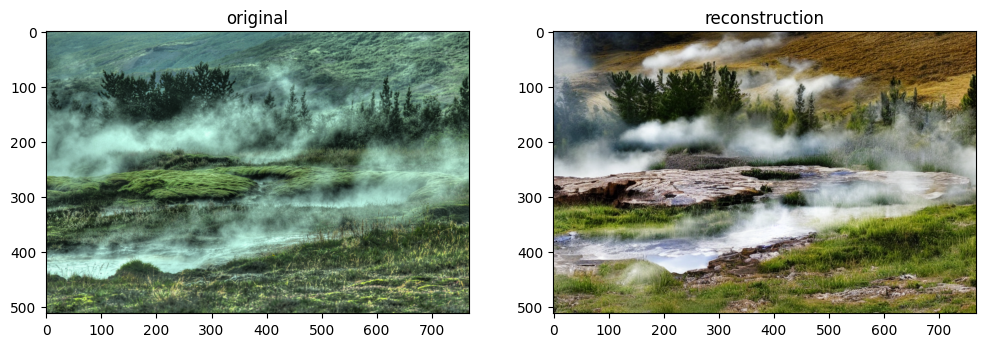

In [33]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(im)
plt.title('original')

plt.subplot(1,2,2)
plt.imshow(xhat)
plt.title('reconstruction')
plt.show()

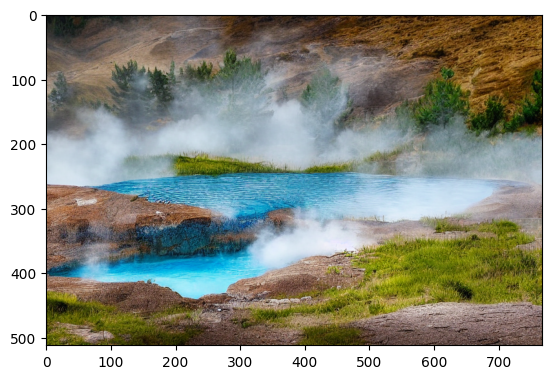

In [34]:
"""TODO: convert to bytes string and call lzma.compress()"""
plt.imshow(canny_map, cmap='gray')

In [125]:
xhat[0][:,:,0].flatten().shape

(393216,)

In [126]:
import lzma
from PIL import Image
import os

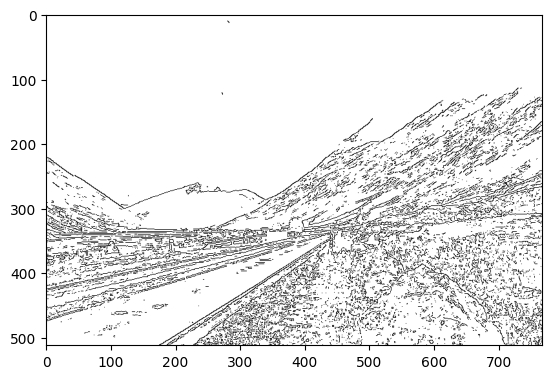

In [127]:
plt.imshow(xhat[0][:,:,0], cmap='gray')

In [30]:
canny_string = bytes(list(xhat[0][:,:,0].flatten() // 255))

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [129]:
compressed = lzma.compress(canny_string)

In [130]:
len(compressed)*8 / (xhat[0].shape[0]*xhat[0].shape[1])

0.4019368489583333

In [131]:
len(canny_string)*8

3145728

In [39]:
xhat[0].shape

(512, 768, 3)

In [43]:
xhat[0][:,:,0]

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ...,   0, 255, 255],
       [255, 255, 255, ...,   0, 255, 255],
       [255, 255, 255, ...,   0, 255, 255]], dtype=uint8)

In [51]:
171936/(512*768)

0.437255859375